### Disinformation Signal Detection in Text

This tool analyzes written content (like news articles or social media posts) to detect **manipulative tactics** often used in disinformation. Instead of just labeling text as true or false, it highlights *how* the content may mislead or emotionally influence readers.

---

#### 🔍 What It Detects

The tool scans for over **40 types of signals**, grouped by tactic:

- **Common Signals**: Emotional manipulation, attacks on credibility, black-and-white thinking
- **Conspiracy Theory**: Secret plots, “suppressed truths,” anonymous insiders
- **Trolling**: Provocative insults, memes, hashtag spam
- **Discrediting**: Personal attacks, fake visuals, smear campaigns
- **Pseudoscience & Denialism**: Fake science claims, cherry-picked evidence
- **Polarization**: Us-vs-them language, exaggerated division
- **Hate/Offensive Speech**: Legacy hate and offensive detectors
- **Clickbait**: Misleading headlines

---

#### ⚙️ How It Works

- Built on a **multilingual AI model** that supports 8 EU languages  
- Uses **prompt-based detection** to ask targeted questions about the text  
- Returns a **multi-label output**: a single text can trigger multiple signals  
- Works on both full documents and specific text segments

---

#### 📤 Output Example

The tool returns:
- A list of detected **signals**
- The **confidence score** for each one
- The exact **text segment** where the signal was found

---

#### 🧩 Why It Matters

This tool helps:
- Understand *how* disinformation is constructed
- Visualize and flag risky content
- Feed results into broader **risk scoring** systems or dashboards


In [ ]:
# 1 ── Install required packages (Polars, Matplotlib, Squarify, Trino client)
%pip install -qU "trino[sqlalchemy]==0.332.0" polars matplotlib squarify


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 2 ── Imports and helper functions
import os, re, json, datetime as dt
from pathlib import Path
from typing import Optional, Tuple
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import squarify
from trino.dbapi import connect

plt.rcParams["figure.dpi"] = 110  # High-resolution plots for clarity

# JSON helpers
def _json_default(value):
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})

# Host/port parser
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    host = (host or "").strip()
    port = (port or "").strip()
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:

# 3 ── Parameters
START_DATE = "2025-03-01"
END_DATE   = "2025-07-25"
TOP_N      = 20

# Trino credentials
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")


In [ ]:
# 4 ── Query Trino
where = ["cn.publish_date IS NOT NULL"]
if START_DATE:
    where.append(f"date(from_iso8601_timestamp(cn.publish_date)) >= DATE '{START_DATE}'")
if END_DATE:
    where.append(f"date(from_iso8601_timestamp(cn.publish_date)) <= DATE '{END_DATE}'")
sql = f"""
SELECT seg.tactic AS tactic
FROM   news.collected_news AS cn
JOIN   tools.text_disinformation_signals_detection AS tdsd
       ON cn.id = tdsd.content_id
CROSS JOIN UNNEST(tdsd.segment) AS seg (spans, level, name, tactic)
CROSS JOIN UNNEST(seg.spans)    AS sp (segment, confidence, start_pos, end_pos, span_value)
WHERE  {" AND ".join(where)}
"""
print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}' (user={TRINO_USER})")
conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur  = conn.cursor()
try:
    cur.execute(sql)
    rows = cur.fetchall()
    columns = [d[0] for d in cur.description]  # ["tactic"]
finally:
    cur.close(); conn.close()

if not rows:
    raise ValueError("No data found in the selected date range.")
print(f"✅ Retrieved {len(rows):,} span‑level rows")


🔌 Connecting to Trino at trino:8080, catalog='iceberg' (user=trino)
✅ Retrieved 233,451 span‑level rows


In [ ]:

# 5 ── Process data
df_all = pl.DataFrame(rows, schema=columns, orient="row")
counts_df = (
    df_all.group_by("tactic")
          .agg(pl.len().alias("count"))
          .sort("count", descending=True)
)
top_counts_df = counts_df.head(TOP_N)

# Prepare treemap inputs
tactics = top_counts_df["tactic"].to_list()
counts  = top_counts_df["count"].to_list()

palette        = list(plt.get_cmap("tab20").colors)
color_map_hex  = {t: mcolors.to_hex(palette[i % len(palette)]) for i, t in enumerate(tactics)}
labels         = [f"{t}\n{c}" for t, c in zip(tactics, counts)]


In [ ]:

# 6 ── Save metadata to JSON
plot_meta = {
    "data"      : top_counts_df.to_dict(as_series=False),
    "title"     : "Treemap – share of each tactic",
    "labels"    : labels,
    "color_map" : color_map_hex,
    "chart_type": "treemap",
    "platform"  : "News"
}
json_path = Path("tactic_treemap.json")
save_dict(plot_meta, json_path)
print(f"💾 Saved JSON → {json_path.resolve()}")


💾 Saved JSON → /home/kadkhoda/tactic_treemap.json


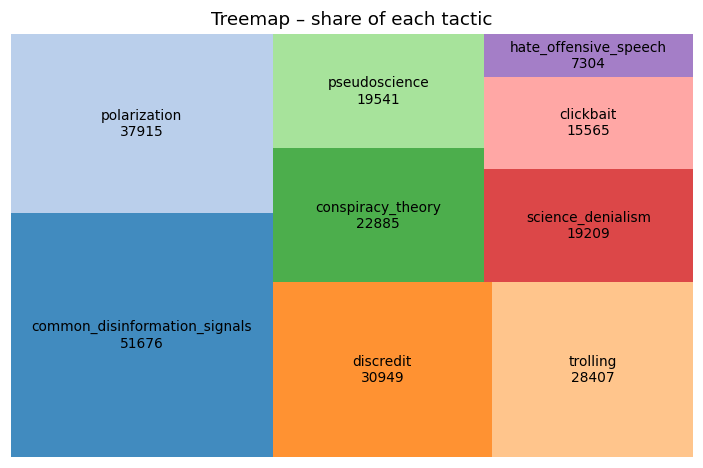

In [ ]:

# 7 ── Load JSON and plot
meta = load_dict(json_path)
df_loaded = df_from_data_d(meta["data"])
tactics_loaded = df_loaded["tactic"].to_list()
counts_loaded  = df_loaded["count"].to_list()
colors_loaded  = [meta["color_map"][t] for t in tactics_loaded]

plt.figure(figsize=(8, 5))
squarify.plot(sizes=counts_loaded,
              label=meta["labels"],
              color=colors_loaded,
              alpha=0.85,
              text_kwargs={"fontsize": 9})
plt.title(meta["title"]); plt.axis("off"); plt.show()
